In [ ]:
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

from src.config import PROCESSED_DATA_DIR

# ======== 1. Đọc dữ liệu và chuẩn hóa ngành hàng ========
assoc_rules = pd.read_csv(f"{PROCESSED_DATA_DIR}/association_rules.csv")
freq_itemsets = pd.read_csv(f"{PROCESSED_DATA_DIR}/frequent_itemsets.csv")
# Nếu có file high utility itemsets thì mở ra luôn
hui_results = pd.read_csv(f"{PROCESSED_DATA_DIR}/hui_results.csv")


def extract_all_items(*series):
    items = []
    for ser in series:
        items += [item for sublist in ser.apply(eval) for item in sublist]
    return items


ants = assoc_rules["antecedent"].apply(eval)
cons = assoc_rules["consequent"].apply(eval)
all_items_assoc = [
    item for sublist in ants.tolist() + cons.tolist() for item in sublist
]
all_items_freq = extract_all_items(freq_itemsets["items"])
all_items_hui = extract_all_items(hui_results["items"])  # Nếu dùng thêm high utility
all_categories = sorted(
    set(all_items_assoc + all_items_freq)
)  # + all_items_hui nếu muốn

N = len(all_categories)

# ======== 2. Tạo affinity matrix (lift) ========
affinity = pd.DataFrame(0.0, index=all_categories, columns=all_categories, dtype=float)
for _, row in assoc_rules.iterrows():
    ants = eval(row["antecedent"])
    cons = eval(row["consequent"])
    lift = row["lift"]
    for a in ants:
        for c in cons:
            if a in affinity.index and c in affinity.columns:
                affinity.loc[a, c] = max(affinity.loc[a, c], lift)
                affinity.loc[c, a] = max(affinity.loc[c, a], lift)

# ======== 3. TỰ ĐỘNG LỌC FORBIDDEN PAIRS (chỉ cặp lift == 0) ========
forbidden_pairs = set()
for i in range(len(all_categories)):
    for j in range(i + 1, len(all_categories)):
        a, b = all_categories[i], all_categories[j]
        if affinity.loc[a, b] == 0.0:
            forbidden_pairs.add((a, b))
print(f"Total forbidden pairs: {len(forbidden_pairs)} / {(N*(N-1))//2}")


# ======== 4. Hàm fitness với SOFT CONSTRAINT ========
def layout_fitness(layout, affinity_matrix):
    score = 0.0
    for i in range(len(layout) - 1):
        score += affinity_matrix.loc[layout[i], layout[i + 1]]
    return score


def eval_layout(individual):
    layout = [all_categories[i] for i in individual]
    penalty = 0
    for i in range(len(layout) - 1):
        a, b = layout[i], layout[i + 1]
        if (a, b) in forbidden_pairs:
            penalty -= 999  # Thay đổi mức phạt tùy ý (-10, -50, -200...)
    return (layout_fitness(layout, affinity) + penalty,)


# ======== 5. Setup GA/DEAP ========
indices_list = list(range(N))

# Khắc phục lỗi DEAP khi chạy nhiều lần
from deap import creator

for cname in ["FitnessMax", "Individual"]:
    if hasattr(creator, cname):
        delattr(creator, cname)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, indices_list, N)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_layout)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Thông số GA
pop_size = 400
ngen = 300
cxpb = 0.9
mutpb = 0.4

pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True
)

# ======== 6. Lấy layout tối ưu & xuất ra file ========
best_indices = hof[0]
best_layout = [all_categories[i] for i in best_indices]
print("\n==> Layout ngành hàng tối ưu (top 10):", best_layout[:10], "...")
print("==> Fitness tối ưu:", layout_fitness(best_layout, affinity))

# Đếm số forbidden pairs thực tế trong layout tối ưu
n_forbidden = sum(
    1
    for i in range(len(best_layout) - 1)
    if (best_layout[i], best_layout[i + 1]) in forbidden_pairs
)
print(f"Số forbidden pairs trong layout tối ưu: {n_forbidden}")

pd.DataFrame({"Category": best_layout}).to_csv(
    f"{PROCESSED_DATA_DIR}/optimal_category_layout.csv", index=False
)

# ======== 7. Vẽ quá trình tiến hóa GA ========
max_fit = [gen["max"] for gen in log]
avg_fit = [gen["avg"] for gen in log]
plt.plot(max_fit, label="Max Fitness")
plt.plot(avg_fit, label="Avg Fitness")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Quá trình tiến hóa GA")
plt.show()


import networkx as nx

G = nx.Graph()
for i in range(len(affinity)):
    for j in range(i + 1, len(affinity)):
        a, b = affinity.index[i], affinity.columns[j]
        value = affinity.iloc[i, j]
        if value > 1:  # hoặc đổi ngưỡng
            G.add_edge(a, b, weight=value)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.4)
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    edge_color=weights,
    edge_cmap=plt.cm.coolwarm,
    width=2,
)
plt.title("Cross-sell cluster network (lift > 1)")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Nếu matrix lớn, lấy top 30 ngành hàng phổ biến nhất (ví dụ theo tổng lift hoặc support)
total_lift = affinity.sum(axis=1) + affinity.sum(axis=0)
top_items = total_lift.sort_values(ascending=False).head(30).index.tolist()
aff_sub = affinity.loc[top_items, top_items]

plt.figure(figsize=(14, 12))
sns.heatmap(aff_sub, annot=False, cmap="coolwarm", square=True)
plt.title("Affinity heatmap (lift) - Top 30 ngành hàng")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

[I 2025-08-08 16:33:31,101] A new study created in memory with name: no-name-2cf5dfce-0421-4bb3-af5a-2dcb80e8d041
[I 2025-08-08 16:33:43,205] Trial 0 finished with value: 38.761263732339515 and parameters: {'lift_threshold': 1.7867988093793141, 'penalty': 38, 'pop_size': 350, 'greedy_ratio': 0.26306883835586703, 'w_lift': 0.2841446780792577, 'w_conf': 0.957553579241725, 'w_margin': 0.207040568896669, 'gamma': 0.9825740757589989, 'k': 9}. Best is trial 0 with value: 38.761263732339515.
[I 2025-08-08 16:34:07,797] Trial 1 finished with value: 47.62558462668338 and parameters: {'lift_threshold': 1.0766234245990471, 'penalty': 125, 'pop_size': 400, 'greedy_ratio': 0.1571003809454714, 'w_lift': 0.8517862056249538, 'w_conf': 0.5615024812554362, 'w_margin': 0.5096995570580503, 'gamma': 0.6388140971813736, 'k': 6}. Best is trial 1 with value: 47.62558462668338.
[I 2025-08-08 16:34:30,206] Trial 2 finished with value: 18.27252803886279 and parameters: {'lift_threshold': 1.3469765941279044, 'pen

Best Optuna params: {'lift_threshold': 0.27755375148195083, 'penalty': 149, 'pop_size': 500, 'greedy_ratio': 0.06615030965820798, 'w_lift': 0.9715517082095857, 'w_conf': 0.5813437080877004, 'w_margin': 0.992215680041783, 'gamma': 0.5030451536255511, 'k': 8}
Best layout (from Optuna): ['Hang say kho', 'San pham an lien', 'Kem cac loai', 'Banh phong, b.trang,snack', 'Banh', 'Thuc an cho vat nuoi', 'Hat, dau rang', 'Banh', 'Tra', 'San pham cham soc co the', 'Banh phong, b.trang,snack', 'Nuoc giai khat khac', 'NCC Chiet khau', 'Khu mui co the', 'Banh', 'San pham an lien', 'Hang do hop', 'Bot cac loai', 'Caphe', 'Cha gio', 'Do dung s.hoat gia dinh', 'SPham cham soc suc khoe', 'Caphe', 'Do dung nau an, uong', 'Khac (rau cau,rong sun)', 'San pham che bien d.lanh', 'Banh', 'Giay ve sinh', 'San pham thong cau, cong', 'Gia vi CL(kho,uot, bngot)', 'Giay ve sinh', 'Keo', 'Socola', 'SPham cham soc rang mieng', 'Hang muoi chua', 'HPham va dung cu cao rau', 'Mat ong', 'Tru mat khac (FLAN)', 'Dung cu 

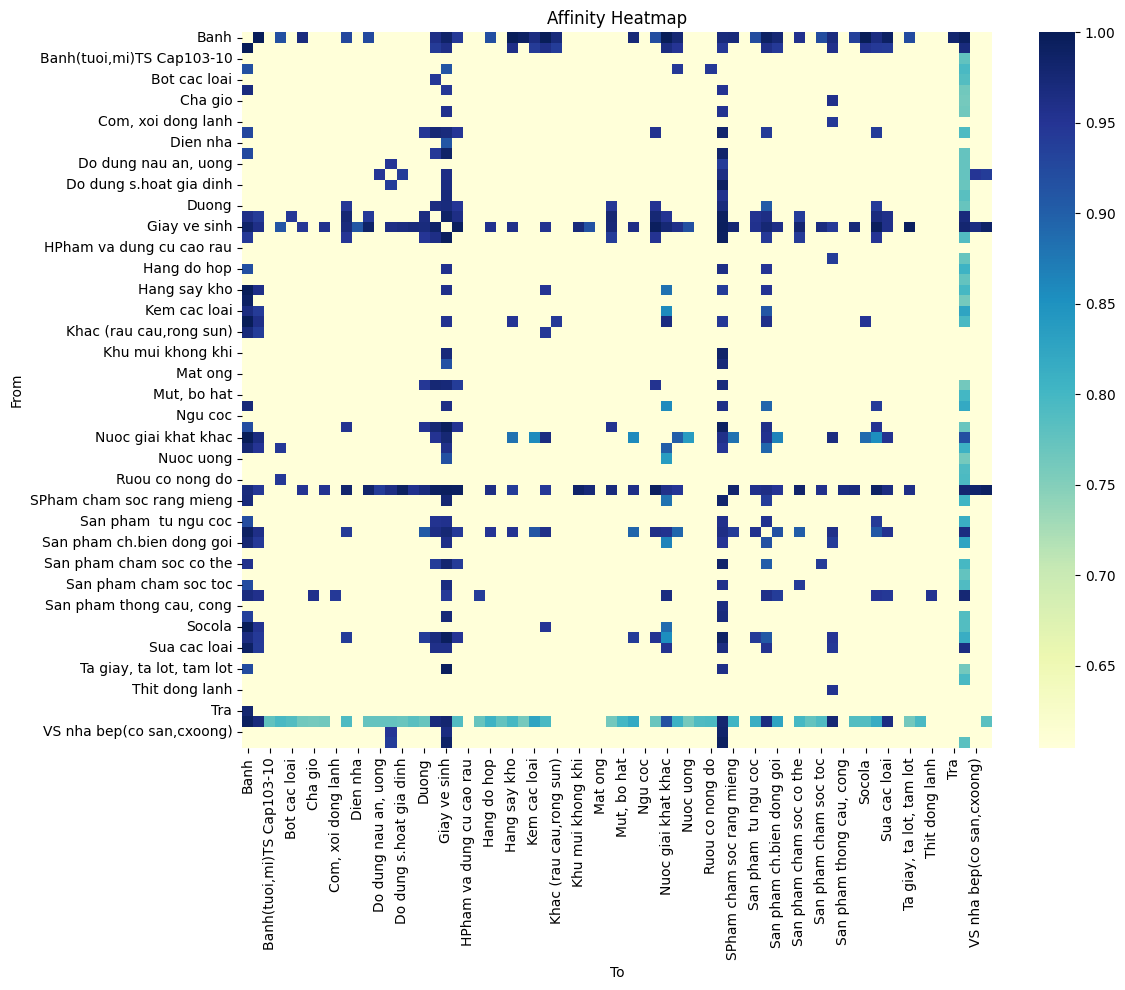

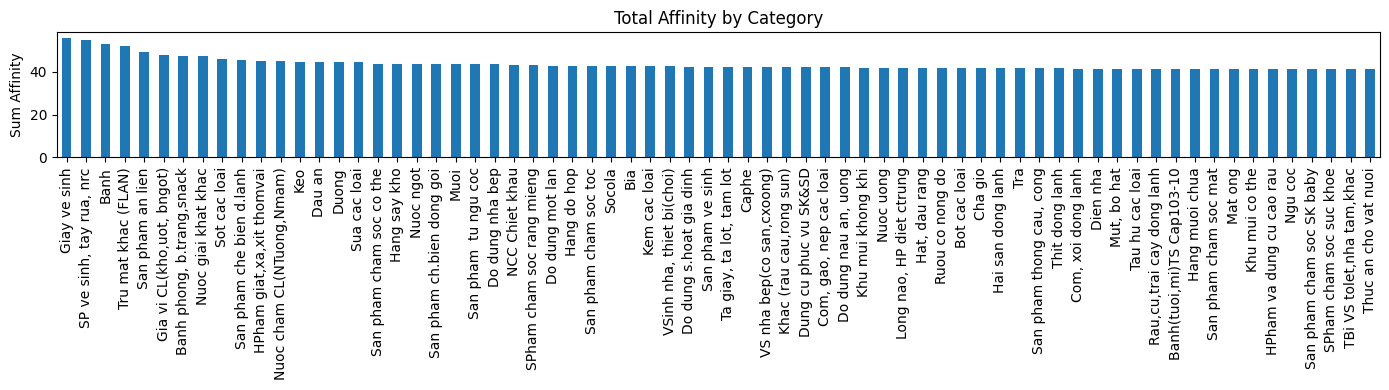

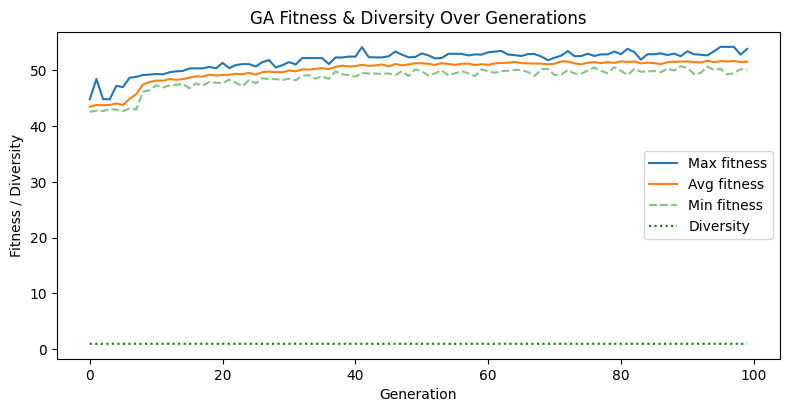

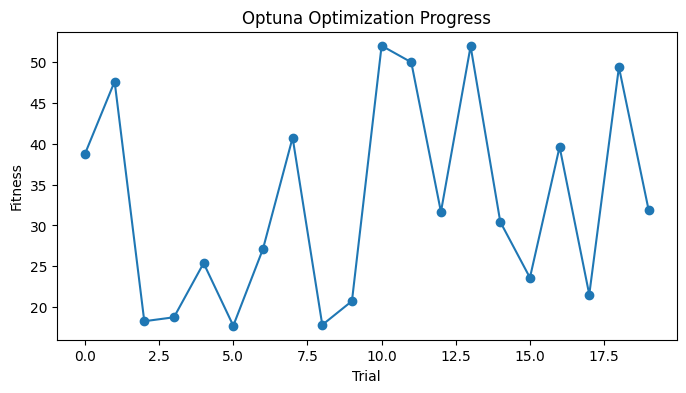

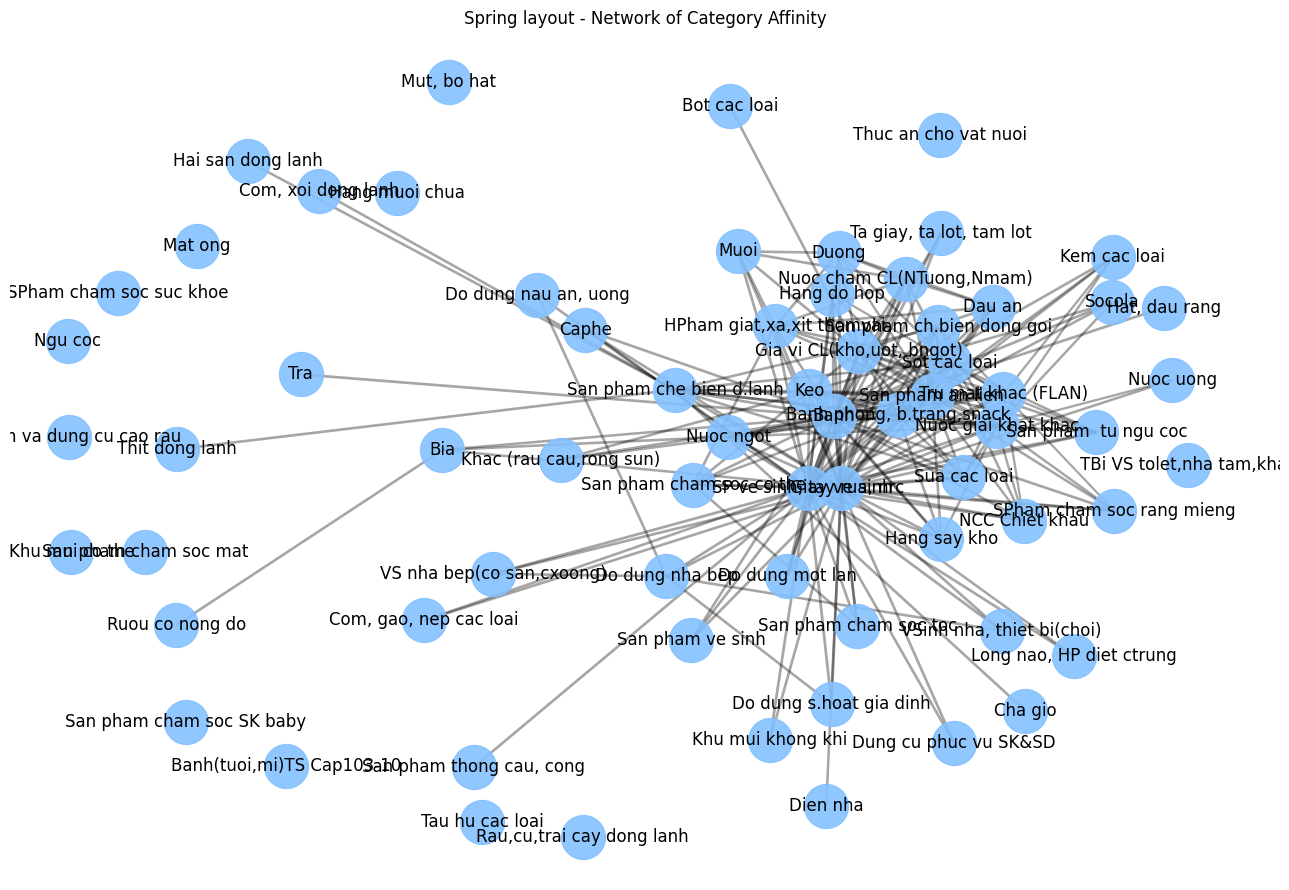

In [ ]:
import ast
import optuna
import pandas as pd
import numpy as np
import random

from src.models.affinity import AffinityBuilder
from src.models.greedy import GreedyLayout
from src.models.cluster_module import ClusterModule
from src.models.forbidden_pairs import get_forbidden_pairs
from src.models.ga_optimizer import GeneticLayoutOptimizer
from src.plots import LayoutVisualizer
from src.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR


# ----- 1. DATA LOADER -----
class DataLoader:
    def __init__(
        self,
        assoc_rules_path,
        freq_itemsets_path,
        layout_real_path,
        margin_matrix_path=None,
    ):
        self.assoc_rules = pd.read_csv(assoc_rules_path)
        self.freq_itemsets = pd.read_csv(freq_itemsets_path)
        self.layout_real = pd.read_csv(layout_real_path).drop_duplicates(keep="first")
        self.margin_matrix = (
            pd.read_csv(margin_matrix_path, index_col=0)
            if margin_matrix_path is not None
            else None
        )
        self._process()

    def _process(self):
        # Parse items safely
        antecedents = self.assoc_rules["antecedent"].apply(ast.literal_eval)
        consequents = self.assoc_rules["consequent"].apply(ast.literal_eval)
        itemsets = self.freq_itemsets["items"].apply(ast.literal_eval)

        all_items = set()
        for ser in antecedents.tolist() + consequents.tolist():
            all_items.update(ser)
        for sublist in itemsets.tolist():
            all_items.update(sublist)
        self.all_items = sorted(all_items)
        # Real categories & positions
        self.real_categories = set(self.layout_real["Category"].dropna().unique())
        # Use 'Step' as position index (1,2,3...) instead of x/y
        self.positions = list(range(1, len(self.layout_real) + 1))


# ----- 2. HARD RULE ENGINE -----


class HardRuleEngine:
    def __init__(self, rules_dict):
        self.rules = rules_dict or {}

    def check_must_at_entry(self, layout):
        req = self.rules.get("must_at_entry")
        return (not req) or (layout and layout[0] == req[0])

    def check_must_at_exit(self, layout):
        req = self.rules.get("must_at_exit")
        return (not req) or (layout and layout[-1] == req[0])

    def check_must_together(self, layout):
        pairs = self.rules.get("must_together", [])
        return all(
            (
                a in layout
                and b in layout
                and abs(layout.index(a) - layout.index(b)) == 1
            )
            for a, b in pairs
        )

    def check_must_order(self, layout):
        pairs = self.rules.get("must_order", [])
        return all(
            (a in layout and b in layout and layout.index(a) < layout.index(b))
            for a, b in pairs
        )

    def check_all(self, layout):
        return {
            "must_at_entry": self.check_must_at_entry(layout),
            "must_at_exit": self.check_must_at_exit(layout),
            "must_together": self.check_must_together(layout),
            "must_order": self.check_must_order(layout),
        }

    def penalty(self, layout, base_penalty=1e6):
        penalty = 0
        if not self.check_must_at_entry(layout):
            penalty += base_penalty
        if not self.check_must_at_exit(layout):
            penalty += base_penalty
        if not self.check_must_together(layout):
            penalty += base_penalty
        if not self.check_must_order(layout):
            penalty += base_penalty
        return penalty


# ----- 3. OPTUNA RUNNER (tích hợp luôn vào pipeline ở đây, nếu muốn tách riêng thì đơn giản) -----

# ----- 4. PIPELINE -----


class LayoutOptimizationPipeline:
    def __init__(
        self,
        data,
        n_trials=30,
        n_gen_final=80,
        use_optuna=True,
        output_path=None,
        ga_selection="tournament",
        ga_crossover="PMX",
        ga_mutation="shuffle",
        ga_adaptive=True,
        ga_ensemble_runs=1,
        hard_rules=None,
        seed=42,
    ):
        # Seed for reproducibility
        self.seed = seed
        np.random.seed(seed)
        random.seed(seed)
        optuna.seed = seed

        # Data
        self.data = data
        self.n_trials = n_trials
        self.n_gen_final = n_gen_final
        self.use_optuna = use_optuna
        self.output_path = output_path or (
            PROCESSED_DATA_DIR / "layout_real_mapped.csv"
        )
        self.ga_selection = ga_selection
        self.ga_crossover = ga_crossover
        self.ga_mutation = ga_mutation
        self.ga_adaptive = ga_adaptive
        self.ga_ensemble_runs = ga_ensemble_runs
        self.hard_rule_engine = HardRuleEngine(hard_rules)

        # Affinity builder
        self.affinity_builder = AffinityBuilder(
            self.data.assoc_rules,
            self.data.freq_itemsets,
            self.data.all_items,
            self.data.margin_matrix,
        )

        # Positions và Real Categories
        self.positions = self.data.positions
        self.real_categories = self.data.real_categories
        self.all_items = self.data.all_items

    def _get_real_layout_as_seed(self):
        layout_real = self.data.layout_real.sort_values("Step")["Category"].tolist()
        return layout_real

    def _filter_layout(self, best_layout):
        # Filter theo real_categories, kiểm tra độ dài
        filtered = best_layout[: len(self.positions)]
        return filtered

    def objective(self, trial):
        # --- Optuna space ---
        lift_threshold = trial.suggest_float("lift_threshold", 0.0, 2.0)
        penalty = trial.suggest_int("penalty", 10, 150)
        pop_size = trial.suggest_int("pop_size", 100, 500, step=50)
        greedy_ratio = trial.suggest_float("greedy_ratio", 0.05, 0.5)
        w_lift = trial.suggest_float("w_lift", 0.1, 1.0)
        w_conf = trial.suggest_float("w_conf", 0.0, 1.0)
        w_margin = trial.suggest_float("w_margin", 0.0, 1.0)
        gamma = trial.suggest_float("gamma", 0.5, 4.0)
        k = trial.suggest_int("k", 3, 10)
        # Normalize weight
        weight_sum = w_lift + w_conf + w_margin
        w_lift, w_conf, w_margin = (
            w_lift / weight_sum,
            w_conf / weight_sum,
            w_margin / weight_sum,
        )
        # Build affinity matrix
        affinity = self.affinity_builder.build_affinity(
            lift_threshold=lift_threshold,
            w_lift=w_lift,
            w_conf=w_conf,
            w_margin=w_margin,
        )
        affinity = self.affinity_builder.normalize(affinity)
        affinity = self.affinity_builder.kernelize(affinity, gamma=gamma)

        greedy_module = GreedyLayout(self.all_items)
        layout_greedy = greedy_module.init_layout(affinity)
        layout_greedy = greedy_module.local_search(layout_greedy, affinity)

        cluster_module = ClusterModule(self.all_items)
        clustered_items = cluster_module.cluster_categories(affinity, k=k)
        forbidden_pairs = get_forbidden_pairs(affinity, self.all_items)
        layout_real = self._get_real_layout_as_seed()
        ga_module = GeneticLayoutOptimizer(
            self.all_items,
            affinity,
            forbidden_pairs,
            penalty=penalty,
            greedy_ratio=greedy_ratio,
            selection=self.ga_selection,
            crossover=self.ga_crossover,
            mutation=self.ga_mutation,
            adaptive=self.ga_adaptive,
            hard_rules=self.hard_rule_engine.rules,
        )

        if self.ga_ensemble_runs > 1:
            best_run, _ = ga_module.run_ensemble(
                ngen=30,
                pop_size=pop_size,
                greedy_layout=layout_greedy,
                n_runs=self.ga_ensemble_runs,
                init_population_extra=[layout_real],  # Seed layout thực tế!
            )
            best_layout = best_run["best_layout"]
            best_fitness = best_run["best_fitness"]
            logbook = best_run["logbook"]
        else:
            best_layout, best_fitness, logbook = ga_module.run(
                ngen=30,
                pop_size=pop_size,
                greedy_layout=layout_greedy,
                record_logbook=True,
                init_population_extra=[layout_real],  # Seed layout thực tế!
            )  # FILTER layout

        filtered_best_layout = self._filter_layout(best_layout)

        # Penalty nếu vi phạm rule cứng
        total_penalty = self.hard_rule_engine.penalty(filtered_best_layout)
        fitness = best_fitness - total_penalty

        # Save info cho best trial
        trial.set_user_attr("best_layout", filtered_best_layout)
        trial.set_user_attr("logbook", logbook)
        return fitness

    def tune(self):
        study = optuna.create_study(direction="maximize")
        study.optimize(self.objective, n_trials=self.n_trials)
        self.study = study
        self.best_params = study.best_params
        # Save layout/logbook của best trial
        best_trial = study.best_trial
        self.best_layout = best_trial.user_attrs["best_layout"]
        self.best_logbook = best_trial.user_attrs["logbook"]
        print("Best Optuna params:", self.best_params)
        print("Best layout (from Optuna):", self.best_layout)
        return study

    def run_final(self):
        # Dùng best params từ Optuna hoặc tune thủ công
        p = self.best_params
        affinity = self.affinity_builder.build_affinity(
            lift_threshold=p["lift_threshold"],
            w_lift=p["w_lift"],
            w_conf=p["w_conf"],
            w_margin=p["w_margin"],
        )
        affinity = self.affinity_builder.normalize(affinity)
        affinity = self.affinity_builder.kernelize(affinity, gamma=p["gamma"])
        greedy_module = GreedyLayout(self.all_items)
        layout_greedy = greedy_module.init_layout(affinity)
        layout_greedy = greedy_module.local_search(layout_greedy, affinity)
        cluster_module = ClusterModule(self.all_items)
        clustered_items = cluster_module.cluster_categories(affinity, k=p["k"])
        forbidden_pairs = get_forbidden_pairs(affinity, self.all_items)

        layout_real = self._get_real_layout_as_seed()  # Lấy layout thực tế chuẩn hóa

        ga_module = GeneticLayoutOptimizer(
            self.all_items,
            affinity,
            forbidden_pairs,
            penalty=p["penalty"],
            greedy_ratio=p["greedy_ratio"],
            selection=self.ga_selection,
            crossover=self.ga_crossover,
            mutation=self.ga_mutation,
            adaptive=self.ga_adaptive,
            hard_rules=self.hard_rule_engine.rules,
        )

        if self.ga_ensemble_runs > 1:
            best_run, all_results = ga_module.run_ensemble(
                ngen=self.n_gen_final,
                pop_size=p["pop_size"],
                greedy_layout=layout_greedy,
                n_runs=self.ga_ensemble_runs,
                init_population_extra=[layout_real],  # Seed layout thực tế!
            )
            best_layout, best_fitness, logbook = (
                best_run["best_layout"],
                best_run["best_fitness"],
                best_run["logbook"],
            )
            self.all_ensemble_results = all_results
        else:
            best_layout, best_fitness, logbook = ga_module.run(
                ngen=self.n_gen_final,
                pop_size=p["pop_size"],
                greedy_layout=layout_greedy,
                record_logbook=True,
                init_population_extra=[layout_real],  # Seed layout thực tế!
            )

        filtered_best_layout = self._filter_layout(best_layout)

        layout_optimal_xy = pd.DataFrame(
            {
                "Category": filtered_best_layout,
                # "x": [p[0] for p in self.positions[: len(filtered_best_layout)]],
                # "y": [p[1] for p in self.positions[: len(filtered_best_layout)]],
            }
        )
        category2cluster = {cat: idx for idx, cat in enumerate(clustered_items)}
        optional_cluster_list = [
            category2cluster.get(cat, -1) for cat in layout_optimal_xy["Category"]
        ]
        layout_optimal_xy.to_csv(self.output_path, index=False)
        print(f"\nBest layout: {filtered_best_layout}")

        # --- CHECK HARD RULES ---
        print("Hard rule checks:")
        rule_check = self.hard_rule_engine.check_all(filtered_best_layout)
        for k, v in rule_check.items():
            print(f"{k}: {v}")
        total_penalty = self.hard_rule_engine.penalty(filtered_best_layout)
        final_fitness = best_fitness - total_penalty
        print(f"Best fitness: {best_fitness:.4f} (after penalty: {final_fitness:.4f})")

        self.layout_optimal_xy = layout_optimal_xy
        self.affinity = affinity
        self.optional_cluster_list = optional_cluster_list
        self.best_fitness = final_fitness
        self.ga_logbook = pd.DataFrame(logbook)
        return layout_optimal_xy, final_fitness

    def plot_all(self):
        if not hasattr(self, "layout_optimal_xy"):
            print("You must run run_final() before plotting.")
            return
        # LayoutVisualizer.visualize_layout_grid(self.layout_optimal_xy)
        LayoutVisualizer.plot_affinity_heatmap(self.affinity)
        LayoutVisualizer.plot_affinity_bar(self.affinity)
        LayoutVisualizer.plot_ga_convergence(self.ga_logbook)
        if hasattr(self, "study"):
            LayoutVisualizer.plot_optuna_trials(self.study)

        LayoutVisualizer.plot_spring_layout(self.affinity, threshold=0.8)


# ----- Example usage -----
hard_rules = {
    # "must_at_entry": ["Banh"],
    # "must_at_exit": ["Keo"],
    # "must_together": [("Banh", "Keo"), ("Bia", "Nuoc ngot")],
    # "must_order": [("Bia", "Nuoc ngot")],
}

df = DataLoader(
    assoc_rules_path=PROCESSED_DATA_DIR / "association_rules.csv",
    freq_itemsets_path=PROCESSED_DATA_DIR / "frequent_itemsets.csv",
    layout_real_path=INTERIM_DATA_DIR / "layout.csv",
    margin_matrix_path=None,
)
pipeline = LayoutOptimizationPipeline(
    data=df,
    n_trials=20,
    n_gen_final=100,
    ga_selection="tournament",
    ga_crossover="PMX",
    ga_mutation="shuffle",
    ga_adaptive=True,
    ga_ensemble_runs=3,
    hard_rules=hard_rules,
    seed=42,
)

pipeline.tune()
pipeline.run_final()
pipeline.plot_all()

c:\Users\lthnhung\AppData\Local\Programs\Python\Python311\Lib\site-packages\tsfresh\__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-08-12 11:23:32.110 | INFO     | src.config:<module>:15 - PROJ_ROOT path is: D:\DataLocal\lthnhung\My Documents\GitHub\Retail-Layout-Optimization-with-ML-Metaheuristics
[I 2025-08-12 11:23:32,193] A new study created in memory with name: no-name-56a522e0-1a66-441f-a73f-c2765639088f
c:\Users\lthnhung\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [120, 500] and step=40, but the range is not divisible by `step`. It will be replaced by [120, 480].
  warnings.warn(
[I 2025-08-12 11:23:36,241] Trial 0 finished with value: 13.098823903467213 and

Best params: {'lift_threshold': 1.2634538277080332, 'w_lift': 0.6984126321133827, 'w_conf': 0.2966621636038555, 'w_margin': 0.3333140400006668, 'gamma': 3.175948164954618, 'w_aff': 1.9694697495218436, 'w_pair': 0.007769696010490058, 'w_entr': 1.4988150763397146, 'gamma_support': 1.1714268039147793, 'pair_threshold': 0.5538695491109077, 'pop_size': 280, 'elite_ratio': 0.07907461849999958, 'penalty': 20}
Best layout (from Optuna): ['Mat ong', 'San pham thong cau, cong', 'SP ve sinh, tay rua, nrc', 'Sua cac loai', 'Dung cu phuc vu SK&SD', 'Do dung nau an, uong', 'Tau hu cac loai', 'Thit dong lanh', 'San pham che bien d.lanh', 'Cha gio', 'Tru mat khac (FLAN)', 'Kem cac loai', 'Rau,cu,trai cay dong lanh', 'Hai san dong lanh', 'Com, xoi dong lanh', 'Com, gao, nep cac loai', 'Giay ve sinh', 'San pham ve sinh', 'San pham cham soc co the', 'SPham cham soc rang mieng', 'San pham cham soc mat', 'San pham cham soc toc', 'San pham cham soc SK baby', 'HPham va dung cu cao rau', 'Banh(tuoi,mi)TS Cap1

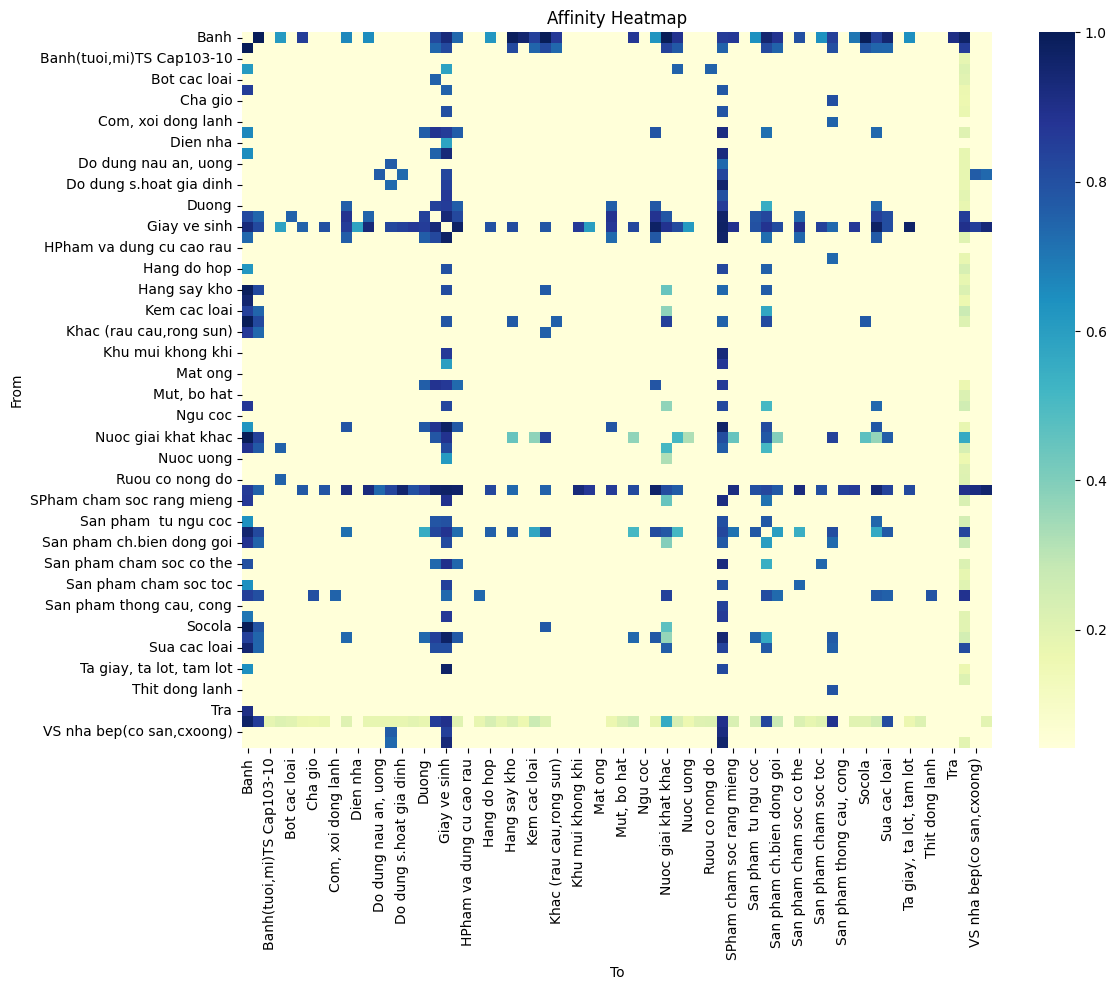

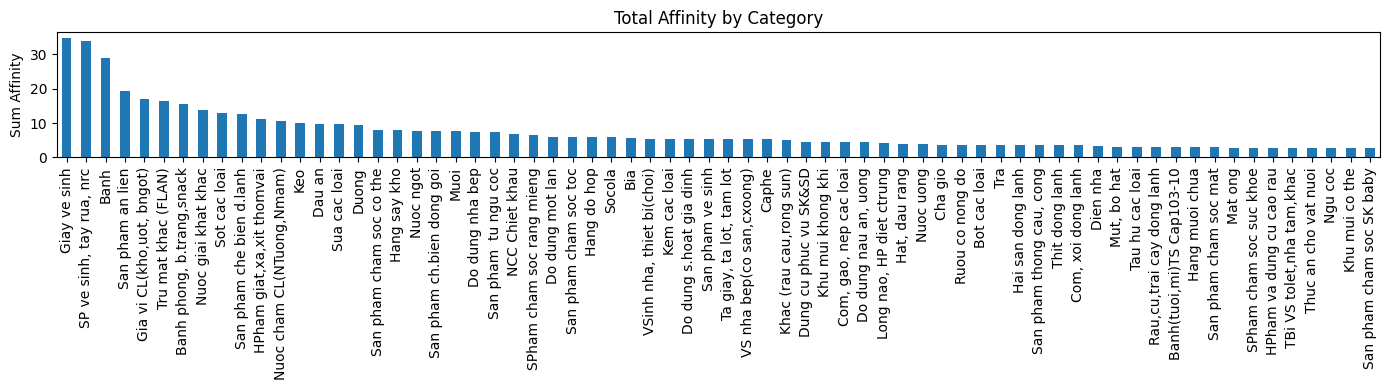

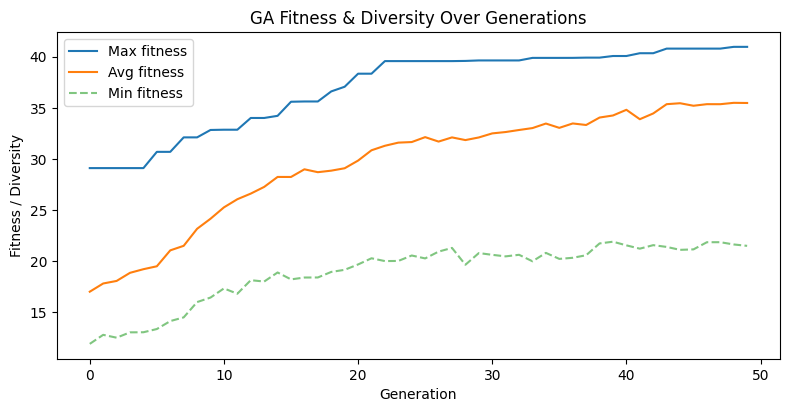

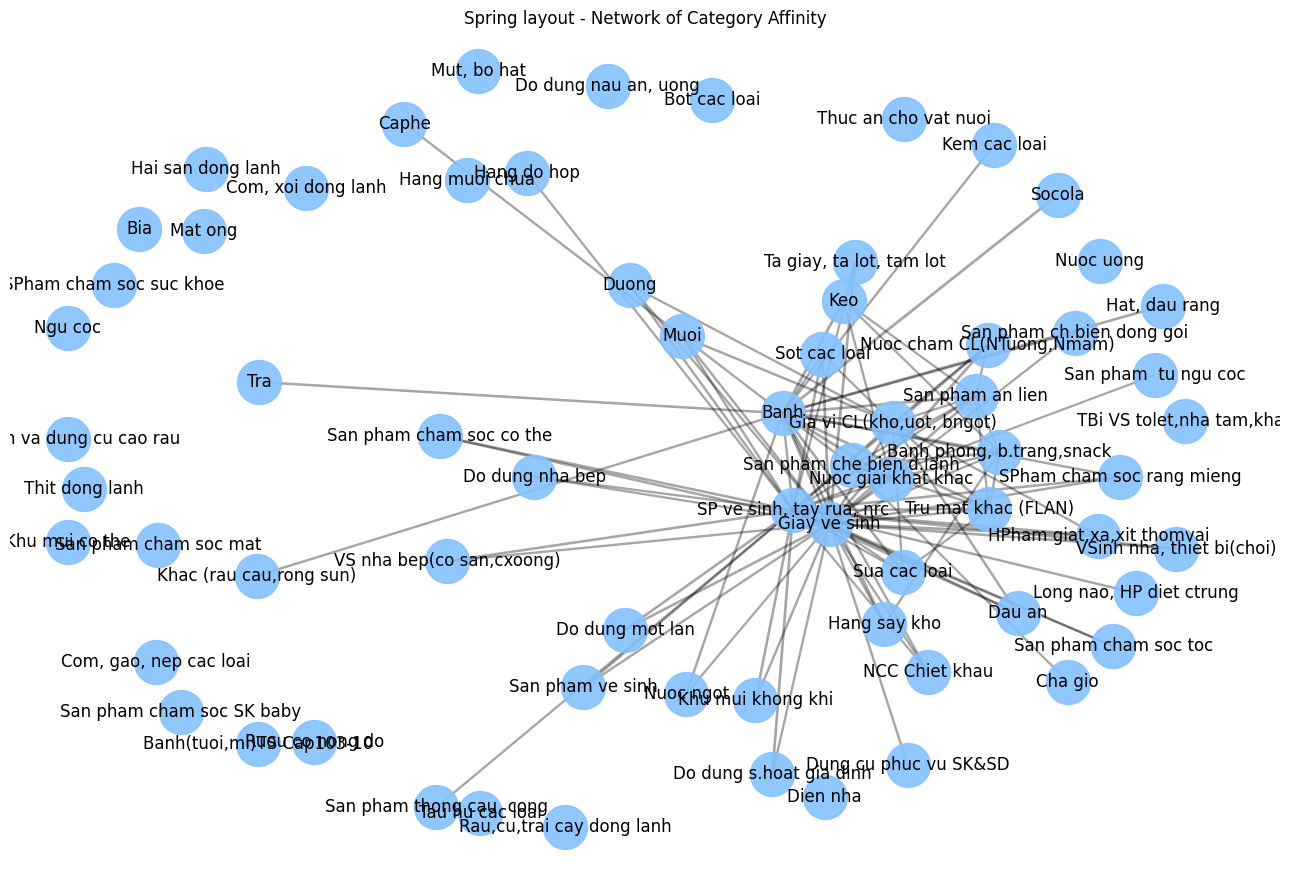